# EM Algorithm for Mixture of Two Exponential Distributions

Implementation of the Expectation-Maximization algorithm for estimating parameters of a mixture model:

$$f(x) = \pi \lambda_1 e^{-\lambda_1 x} + (1-\pi) \lambda_2 e^{-\lambda_2 x}$$

where $x > 0$ and parameters to estimate are $(\pi, \lambda_1, \lambda_2)$.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

np.random.seed(42)

## Generate Synthetic Data

Create sample data from known mixture for validation.

In [14]:
# True parameters
true_pi = 0.4
true_lambda1 = 2.0
true_lambda2 = 0.5
n_samples = 1000

# Generate mixture data
component = np.random.binomial(1, true_pi, n_samples)
X = np.where(
    component == 1,
    np.random.exponential(1/true_lambda1, n_samples),
    np.random.exponential(1/true_lambda2, n_samples)
)

print(f"Data generated: n={len(X)}, min={X.min():.3f}, max={X.max():.3f}, mean={X.mean():.3f}")
print(f"True parameters: π={true_pi}, λ1={true_lambda1}, λ2={true_lambda2}")

Data generated: n=1000, min=0.000, max=10.780, mean=1.440
True parameters: π=0.4, λ1=2.0, λ2=0.5


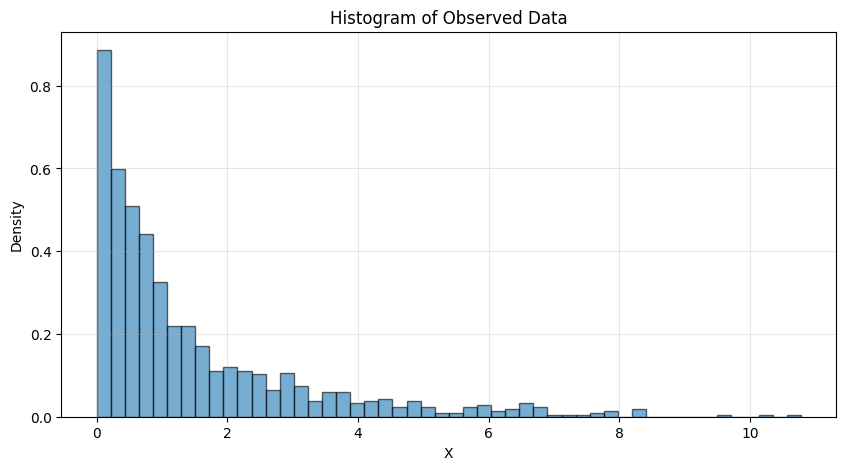

In [15]:
# Visualize data
plt.figure(figsize=(10, 5))
plt.hist(X, bins=50, density=True, alpha=0.6, edgecolor='black')
plt.xlabel('X')
plt.ylabel('Density')
plt.title('Histogram of Observed Data')
plt.grid(True, alpha=0.3)
plt.show()

## EM Algorithm Implementation

### E-step
Calculate conditional probability that observation $i$ came from component 1:

$$p_i^{(l)} = \frac{\pi^{(l)} \lambda_1^{(l)} e^{-\lambda_1^{(l)} X_i}}{\pi^{(l)} \lambda_1^{(l)} e^{-\lambda_1^{(l)} X_i} + (1-\pi^{(l)}) \lambda_2^{(l)} e^{-\lambda_2^{(l)} X_i}}$$

### M-step
Update parameters:

$$\pi^{(l+1)} = \frac{1}{n} \sum_{i=1}^n p_i^{(l)}$$

$$\lambda_1^{(l+1)} = \frac{\sum_{i=1}^n p_i^{(l)}}{\sum_{i=1}^n p_i^{(l)} X_i}$$

$$\lambda_2^{(l+1)} = \frac{\sum_{i=1}^n (1-p_i^{(l)})}{\sum_{i=1}^n (1-p_i^{(l)}) X_i}$$

In [16]:
def e_step(X, pi, lambda1, lambda2):
    """
    E-step: Calculate posterior probabilities.
    
    Returns:
        p: Array of probabilities that each observation belongs to component 1
    """
    # Component 1 likelihood
    likelihood1 = pi * lambda1 * np.exp(-lambda1 * X)
    
    # Component 2 likelihood
    likelihood2 = (1 - pi) * lambda2 * np.exp(-lambda2 * X)
    
    # Posterior probability for component 1
    p = likelihood1 / (likelihood1 + likelihood2)
    
    return p


def m_step(X, p):
    """
    M-step: Update parameter estimates.
    
    Returns:
        pi, lambda1, lambda2: Updated parameter estimates
    """
    n = len(X)
    
    # Update mixing probability
    pi = np.mean(p)
    
    # Update lambda1
    lambda1 = np.sum(p) / np.sum(p * X)
    
    # Update lambda2
    lambda2 = np.sum(1 - p) / np.sum((1 - p) * X)
    
    return pi, lambda1, lambda2


def log_likelihood(X, pi, lambda1, lambda2):
    """
    Calculate log-likelihood of the observed data.
    """
    likelihood1 = pi * lambda1 * np.exp(-lambda1 * X)
    likelihood2 = (1 - pi) * lambda2 * np.exp(-lambda2 * X)
    return np.sum(np.log(likelihood1 + likelihood2))


def em_algorithm(X, pi_init=0.5, lambda1_init=1.0, lambda2_init=1.0, 
                 max_iter=100, tol=1e-6, verbose=True):
    """
    Run EM algorithm until convergence.
    
    Parameters:
        X: Observed data
        pi_init, lambda1_init, lambda2_init: Initial parameter values
        max_iter: Maximum iterations
        tol: Convergence tolerance for log-likelihood
        verbose: Print progress
    
    Returns:
        Dictionary with final parameters and convergence history
    """
    # Initialize
    pi = pi_init
    lambda1 = lambda1_init
    lambda2 = lambda2_init
    
    # Track convergence
    history = {
        'pi': [pi],
        'lambda1': [lambda1],
        'lambda2': [lambda2],
        'log_likelihood': [log_likelihood(X, pi, lambda1, lambda2)]
    }
    
    if verbose:
        print(f"Iteration 0: π={pi:.4f}, λ1={lambda1:.4f}, λ2={lambda2:.4f}, LL={history['log_likelihood'][0]:.4f}")
    
    for iteration in range(1, max_iter + 1):
        # E-step
        p = e_step(X, pi, lambda1, lambda2)
        
        # M-step
        pi, lambda1, lambda2 = m_step(X, p)
        
        # Calculate log-likelihood
        ll = log_likelihood(X, pi, lambda1, lambda2)
        
        # Store history
        history['pi'].append(pi)
        history['lambda1'].append(lambda1)
        history['lambda2'].append(lambda2)
        history['log_likelihood'].append(ll)
        
        if verbose and iteration % 10 == 0:
            print(f"Iteration {iteration}: π={pi:.4f}, λ1={lambda1:.4f}, λ2={lambda2:.4f}, LL={ll:.4f}")
        
        # Check convergence
        if abs(ll - history['log_likelihood'][-2]) < tol:
            if verbose:
                print(f"\nConverged at iteration {iteration}")
            break
    
    return {
        'pi': pi,
        'lambda1': lambda1,
        'lambda2': lambda2,
        'log_likelihood': ll,
        'iterations': iteration,
        'history': history,
        'posterior_probs': p
    }

## Run EM Algorithm

In [17]:
# Run with different initializations
result = em_algorithm(X, pi_init=0.5, lambda1_init=1.0, lambda2_init=1.0, verbose=True)

print("\n" + "="*60)
print("ESTIMATION RESULTS")
print("="*60)
print(f"\nEstimated parameters:")
print(f"  π  = {result['pi']:.4f} (true: {true_pi:.4f})")
print(f"  λ1 = {result['lambda1']:.4f} (true: {true_lambda1:.4f})")
print(f"  λ2 = {result['lambda2']:.4f} (true: {true_lambda2:.4f})")
print(f"\nLog-likelihood: {result['log_likelihood']:.4f}")
print(f"Iterations: {result['iterations']}")

Iteration 0: π=0.5000, λ1=1.0000, λ2=1.0000, LL=-1439.7074

Converged at iteration 2

ESTIMATION RESULTS

Estimated parameters:
  π  = 0.5000 (true: 0.4000)
  λ1 = 0.6946 (true: 2.0000)
  λ2 = 0.6946 (true: 0.5000)

Log-likelihood: -1364.4399
Iterations: 2


## Convergence Analysis

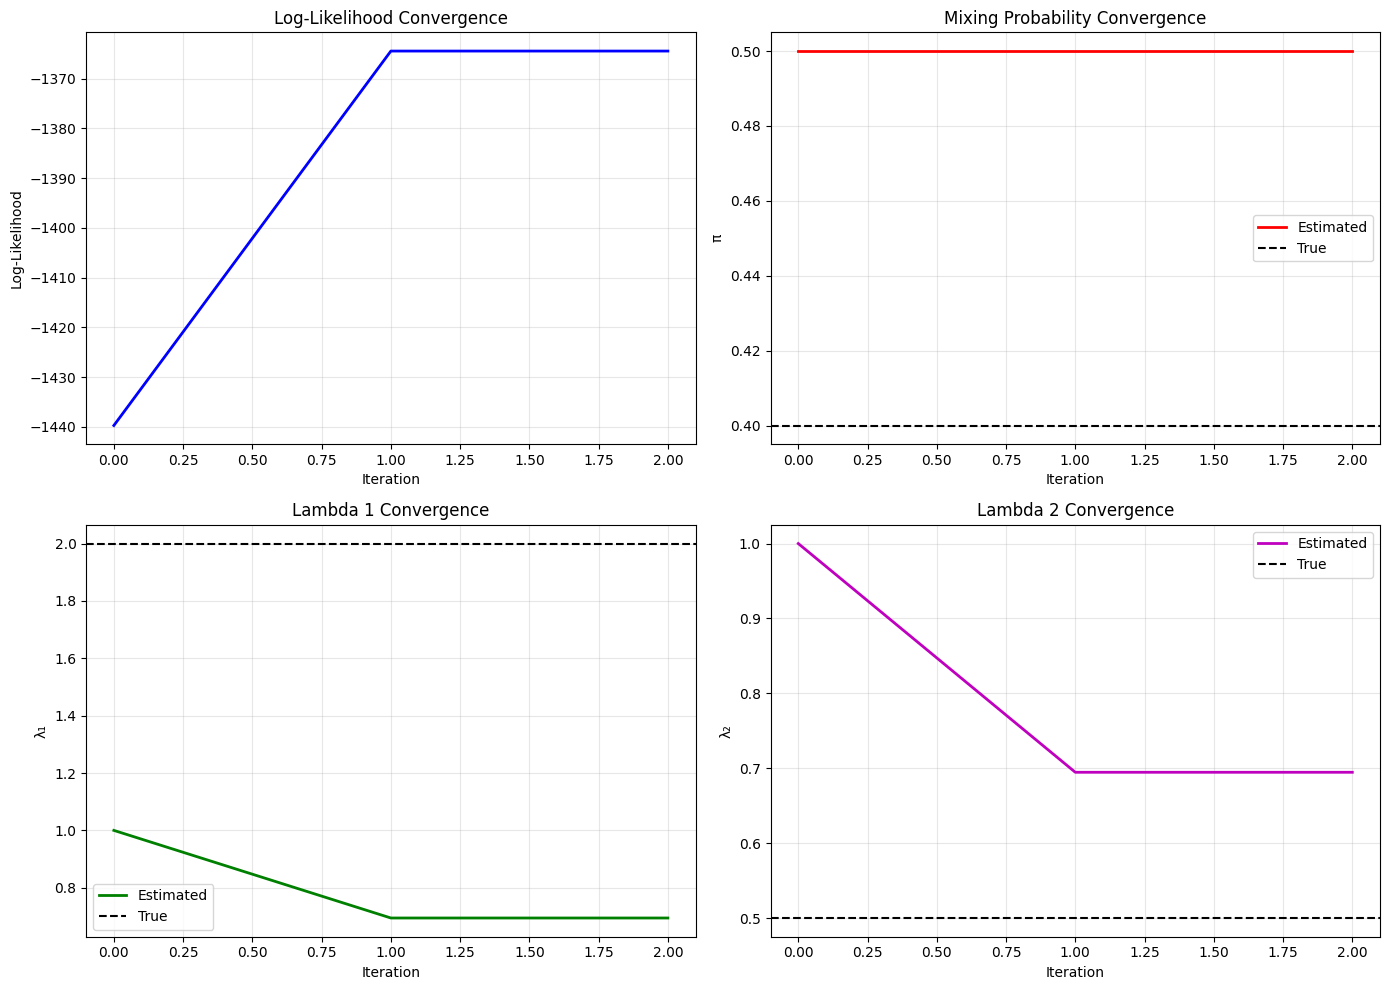

In [18]:
# Plot convergence
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Log-likelihood
axes[0, 0].plot(result['history']['log_likelihood'], 'b-', linewidth=2)
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Log-Likelihood')
axes[0, 0].set_title('Log-Likelihood Convergence')
axes[0, 0].grid(True, alpha=0.3)

# Pi convergence
axes[0, 1].plot(result['history']['pi'], 'r-', linewidth=2, label='Estimated')
axes[0, 1].axhline(y=true_pi, color='k', linestyle='--', label='True')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('π')
axes[0, 1].set_title('Mixing Probability Convergence')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Lambda1 convergence
axes[1, 0].plot(result['history']['lambda1'], 'g-', linewidth=2, label='Estimated')
axes[1, 0].axhline(y=true_lambda1, color='k', linestyle='--', label='True')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('λ₁')
axes[1, 0].set_title('Lambda 1 Convergence')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Lambda2 convergence
axes[1, 1].plot(result['history']['lambda2'], 'm-', linewidth=2, label='Estimated')
axes[1, 1].axhline(y=true_lambda2, color='k', linestyle='--', label='True')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('λ₂')
axes[1, 1].set_title('Lambda 2 Convergence')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Model Fit Visualization

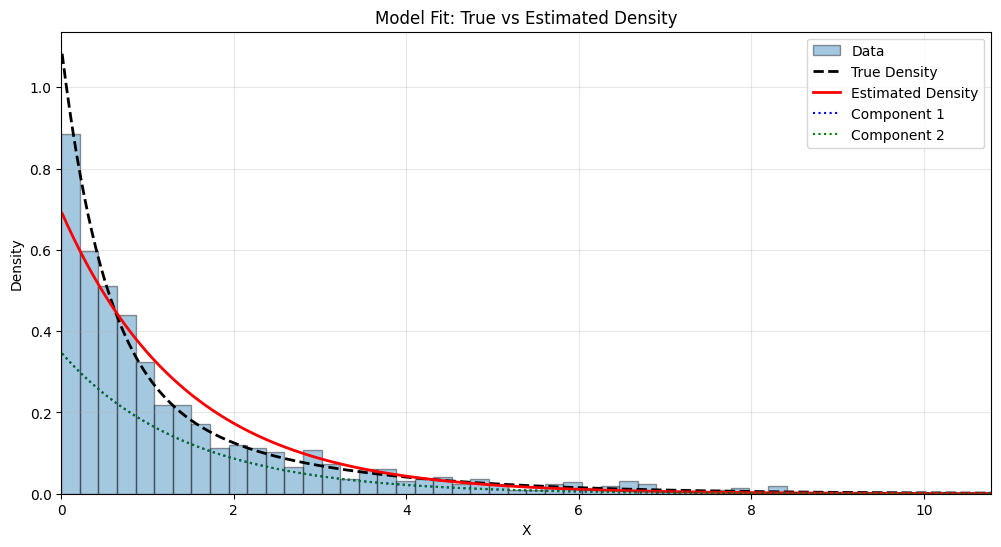

In [19]:
# Plot fitted density
x_range = np.linspace(0.01, X.max(), 1000)

# True density
true_density = (true_pi * true_lambda1 * np.exp(-true_lambda1 * x_range) + 
                (1 - true_pi) * true_lambda2 * np.exp(-true_lambda2 * x_range))

# Estimated density
est_density = (result['pi'] * result['lambda1'] * np.exp(-result['lambda1'] * x_range) + 
               (1 - result['pi']) * result['lambda2'] * np.exp(-result['lambda2'] * x_range))

# Component densities
comp1_density = result['pi'] * result['lambda1'] * np.exp(-result['lambda1'] * x_range)
comp2_density = (1 - result['pi']) * result['lambda2'] * np.exp(-result['lambda2'] * x_range)

plt.figure(figsize=(12, 6))
plt.hist(X, bins=50, density=True, alpha=0.4, edgecolor='black', label='Data')
plt.plot(x_range, true_density, 'k--', linewidth=2, label='True Density')
plt.plot(x_range, est_density, 'r-', linewidth=2, label='Estimated Density')
plt.plot(x_range, comp1_density, 'b:', linewidth=1.5, label='Component 1')
plt.plot(x_range, comp2_density, 'g:', linewidth=1.5, label='Component 2')
plt.xlabel('X')
plt.ylabel('Density')
plt.title('Model Fit: True vs Estimated Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, x_range.max())
plt.show()

## Component Assignment Analysis

In [20]:
# Classify observations based on posterior probabilities
predicted_component = (result['posterior_probs'] > 0.5).astype(int) + 1

# True component assignment
true_component = component + 1

# Classification accuracy
accuracy = np.mean(predicted_component == true_component)
print(f"Classification accuracy: {accuracy:.2%}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_component, predicted_component)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, 
                   columns=['Predicted Component 1', 'Predicted Component 2'],
                   index=['True Component 1', 'True Component 2']))

Classification accuracy: 61.30%

Confusion Matrix:
                  Predicted Component 1  Predicted Component 2
True Component 1                    613                      0
True Component 2                    387                      0


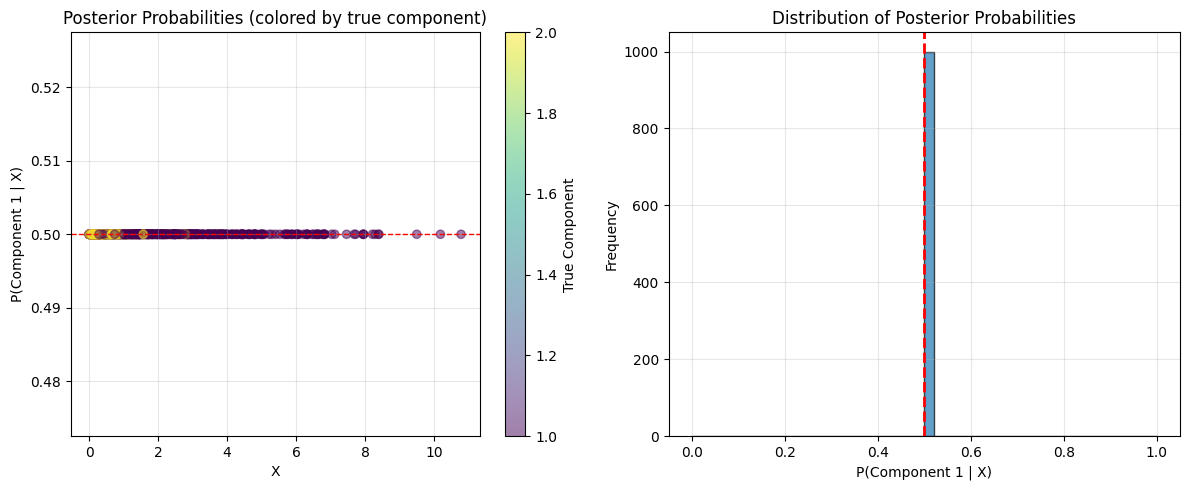

In [21]:
# Scatter plot of posterior probabilities
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X, result['posterior_probs'], c=true_component, cmap='viridis', alpha=0.5)
plt.axhline(y=0.5, color='r', linestyle='--', linewidth=1)
plt.xlabel('X')
plt.ylabel('P(Component 1 | X)')
plt.title('Posterior Probabilities (colored by true component)')
plt.colorbar(label='True Component')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(result['posterior_probs'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0.5, color='r', linestyle='--', linewidth=2)
plt.xlabel('P(Component 1 | X)')
plt.ylabel('Frequency')
plt.title('Distribution of Posterior Probabilities')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Sensitivity to Initialization

In [22]:
# Test multiple random initializations
n_inits = 10
init_results = []

np.random.seed(123)
for i in range(n_inits):
    pi_init = np.random.uniform(0.2, 0.8)
    lambda1_init = np.random.uniform(0.5, 3.0)
    lambda2_init = np.random.uniform(0.5, 3.0)
    
    res = em_algorithm(X, pi_init, lambda1_init, lambda2_init, verbose=False)
    init_results.append({
        'pi_init': pi_init,
        'lambda1_init': lambda1_init,
        'lambda2_init': lambda2_init,
        'pi_final': res['pi'],
        'lambda1_final': res['lambda1'],
        'lambda2_final': res['lambda2'],
        'log_likelihood': res['log_likelihood'],
        'iterations': res['iterations']
    })

init_df = pd.DataFrame(init_results)
print("\nSensitivity Analysis - Multiple Initializations:")
print(init_df[['pi_final', 'lambda1_final', 'lambda2_final', 'log_likelihood', 'iterations']].round(4))
print(f"\nLog-likelihood range: [{init_df['log_likelihood'].min():.4f}, {init_df['log_likelihood'].max():.4f}]")
print(f"All converged to same solution: {np.allclose(init_df['log_likelihood'], init_df['log_likelihood'].iloc[0])}")


Sensitivity Analysis - Multiple Initializations:
   pi_final  lambda1_final  lambda2_final  log_likelihood  iterations
0    0.3623         1.9853         0.5072      -1334.8475         100
1    0.3506         2.0397         0.5122      -1334.8229         100
2    0.3664         1.9670         0.5055      -1334.8627         100
3    0.6492         0.5122         2.0390      -1334.8230         100
4    0.6465         0.5110         2.0261      -1334.8262         100
5    0.3699         1.9519         0.5040      -1334.8783         100
6    0.6475         0.5114         2.0305      -1334.8249         100
7    0.3645         1.9754         0.5063      -1334.8553         100
8    0.6503         0.5126         2.0439      -1334.8222         100
9    0.6445         0.5101         2.0168      -1334.8296         100

Log-likelihood range: [-1334.8783, -1334.8222]
All converged to same solution: False


## Q-Function Analysis

The Q-function for this mixture model:

$$Q(\pi, \lambda_1, \lambda_2 | \{X_i\}_{i=1}^n, \{p_i^{(l)}\}_{i=1}^n) = \sum_{i=1}^n p_i^{(l)}(\log \pi + \log \lambda_1 - \lambda_1 X_i) + (1-p_i^{(l)})(\log(1-\pi) + \log \lambda_2 - \lambda_2 X_i)$$

In [23]:
def q_function(X, p, pi, lambda1, lambda2):
    """
    Calculate Q-function value.
    """
    term1 = p * (np.log(pi) + np.log(lambda1) - lambda1 * X)
    term2 = (1 - p) * (np.log(1 - pi) + np.log(lambda2) - lambda2 * X)
    return np.sum(term1 + term2)

# Calculate Q-function at final iteration
final_p = result['posterior_probs']
q_val = q_function(X, final_p, result['pi'], result['lambda1'], result['lambda2'])
print(f"Q-function value at convergence: {q_val:.4f}")
print(f"Log-likelihood at convergence: {result['log_likelihood']:.4f}")

Q-function value at convergence: -2057.5871
Log-likelihood at convergence: -1364.4399


## Direct Optimization Approach

Since EM can get stuck in local optima, let's use direct optimization to maximize the log-likelihood.

In [24]:
from scipy.optimize import minimize, differential_evolution

def negative_log_likelihood(params, X):
    """
    Negative log-likelihood function for minimization.
    
    Parameters:
        params: [pi, lambda1, lambda2]
        X: Observed data
    """
    pi, lambda1, lambda2 = params
    
    # Add small epsilon to avoid numerical issues
    eps = 1e-10
    
    # Check parameter bounds
    if pi <= 0 or pi >= 1 or lambda1 <= 0 or lambda2 <= 0:
        return np.inf
    
    # Calculate mixture likelihood
    likelihood1 = pi * lambda1 * np.exp(-lambda1 * X)
    likelihood2 = (1 - pi) * lambda2 * np.exp(-lambda2 * X)
    total_likelihood = likelihood1 + likelihood2
    
    # Avoid log(0)
    total_likelihood = np.maximum(total_likelihood, eps)
    
    # Return negative log-likelihood
    return -np.sum(np.log(total_likelihood))


def optimize_mixture(X, method='L-BFGS-B', pi_init=0.5, lambda1_init=1.0, lambda2_init=1.0):
    """
    Optimize mixture parameters using direct minimization.
    
    Parameters:
        X: Observed data
        method: Optimization method
        pi_init, lambda1_init, lambda2_init: Initial parameter values
    
    Returns:
        Optimization result
    """
    # Initial parameters
    params_init = [pi_init, lambda1_init, lambda2_init]
    
    # Parameter bounds: pi in (0,1), lambdas > 0
    bounds = [(0.01, 0.99), (0.01, 10), (0.01, 10)]
    
    # Optimize
    result = minimize(
        negative_log_likelihood,
        params_init,
        args=(X,),
        method=method,
        bounds=bounds,
        options={'maxiter': 1000}
    )
    
    return result


def optimize_mixture_global(X):
    """
    Use global optimization (Differential Evolution) to find the best parameters.
    This helps avoid local optima by searching the entire parameter space.
    """
    bounds = [(0.01, 0.99), (0.01, 10), (0.01, 10)]
    
    result = differential_evolution(
        negative_log_likelihood,
        bounds,
        args=(X,),
        strategy='best1bin',
        maxiter=1000,
        popsize=15,
        tol=1e-7,
        seed=42,
        polish=True,  # Use L-BFGS-B to polish the best solution
        workers=1
    )
    
    return result

### Run Direct Optimization

In [25]:
# Try multiple local optimization runs with different initializations
print("="*60)
print("LOCAL OPTIMIZATION (L-BFGS-B) - Multiple Initializations")
print("="*60)

np.random.seed(42)
n_runs = 5
local_results = []

for i in range(n_runs):
    pi_init = np.random.uniform(0.2, 0.8)
    lambda1_init = np.random.uniform(0.5, 3.0)
    lambda2_init = np.random.uniform(0.5, 3.0)
    
    res = optimize_mixture(X, method='L-BFGS-B', 
                          pi_init=pi_init, 
                          lambda1_init=lambda1_init, 
                          lambda2_init=lambda2_init)
    
    if res.success:
        pi_opt, lambda1_opt, lambda2_opt = res.x
        ll = -res.fun
        local_results.append({
            'pi': pi_opt,
            'lambda1': lambda1_opt,
            'lambda2': lambda2_opt,
            'log_likelihood': ll,
            'success': res.success
        })
        print(f"Run {i+1}: π={pi_opt:.4f}, λ1={lambda1_opt:.4f}, λ2={lambda2_opt:.4f}, LL={ll:.4f}")

# Find best local result
best_local = max(local_results, key=lambda x: x['log_likelihood'])

print("\n" + "="*60)
print("BEST LOCAL OPTIMIZATION RESULT")
print("="*60)
print(f"π  = {best_local['pi']:.4f} (true: {true_pi:.4f})")
print(f"λ1 = {best_local['lambda1']:.4f} (true: {true_lambda1:.4f})")
print(f"λ2 = {best_local['lambda2']:.4f} (true: {true_lambda2:.4f})")
print(f"Log-likelihood: {best_local['log_likelihood']:.4f}")

LOCAL OPTIMIZATION (L-BFGS-B) - Multiple Initializations
Run 1: π=0.3466, λ1=2.0591, λ2=0.5139, LL=-1334.8211
Run 2: π=0.6535, λ1=0.5140, λ2=2.0592, LL=-1334.8211
Run 3: π=0.3466, λ1=2.0591, λ2=0.5139, LL=-1334.8211
Run 4: π=0.6534, λ1=0.5139, λ2=2.0591, LL=-1334.8211
Run 5: π=0.3466, λ1=2.0591, λ2=0.5139, LL=-1334.8211

BEST LOCAL OPTIMIZATION RESULT
π  = 0.3466 (true: 0.4000)
λ1 = 2.0591 (true: 2.0000)
λ2 = 0.5139 (true: 0.5000)
Log-likelihood: -1334.8211


### Global Optimization (Differential Evolution)

This searches the entire parameter space to avoid local optima.

In [26]:
print("\n" + "="*60)
print("GLOBAL OPTIMIZATION (Differential Evolution)")
print("="*60)

global_result = optimize_mixture_global(X)

pi_global, lambda1_global, lambda2_global = global_result.x
ll_global = -global_result.fun

print(f"\nGlobal optimization result:")
print(f"  π  = {pi_global:.4f} (true: {true_pi:.4f})")
print(f"  λ1 = {lambda1_global:.4f} (true: {true_lambda1:.4f})")
print(f"  λ2 = {lambda2_global:.4f} (true: {true_lambda2:.4f})")
print(f"\nLog-likelihood: {ll_global:.4f}")
print(f"Success: {global_result.success}")
print(f"Function evaluations: {global_result.nfev}")


GLOBAL OPTIMIZATION (Differential Evolution)

Global optimization result:
  π  = 0.6535 (true: 0.4000)
  λ1 = 0.5140 (true: 2.0000)
  λ2 = 2.0594 (true: 0.5000)

Log-likelihood: -1334.8211
Success: True
Function evaluations: 2082


### Comparison: EM vs Direct Optimization

In [27]:
# Create comparison table
comparison_data = {
    'Method': ['True Parameters', 'EM Algorithm', 'Local Optimization (Best)', 'Global Optimization'],
    'π': [true_pi, result['pi'], best_local['pi'], pi_global],
    'λ1': [true_lambda1, result['lambda1'], best_local['lambda1'], lambda1_global],
    'λ2': [true_lambda2, result['lambda2'], best_local['lambda2'], lambda2_global],
    'Log-Likelihood': [np.nan, result['log_likelihood'], best_local['log_likelihood'], ll_global]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("COMPARISON: EM vs DIRECT OPTIMIZATION")
print("="*80)
print(comparison_df.to_string(index=False))

# Calculate errors
print("\n" + "="*80)
print("PARAMETER ERRORS")
print("="*80)
for method, pi_est, lambda1_est, lambda2_est in [
    ('EM Algorithm', result['pi'], result['lambda1'], result['lambda2']),
    ('Local Optimization', best_local['pi'], best_local['lambda1'], best_local['lambda2']),
    ('Global Optimization', pi_global, lambda1_global, lambda2_global)
]:
    pi_error = abs(pi_est - true_pi)
    lambda1_error = abs(lambda1_est - true_lambda1)
    lambda2_error = abs(lambda2_est - true_lambda2)
    total_error = pi_error + lambda1_error + lambda2_error
    
    print(f"\n{method}:")
    print(f"  |π - true|:  {pi_error:.4f}")
    print(f"  |λ1 - true|: {lambda1_error:.4f}")
    print(f"  |λ2 - true|: {lambda2_error:.4f}")
    print(f"  Total error: {total_error:.4f}")


COMPARISON: EM vs DIRECT OPTIMIZATION
                   Method        π       λ1       λ2  Log-Likelihood
          True Parameters 0.400000 2.000000 0.500000             NaN
             EM Algorithm 0.500000 0.694586 0.694586    -1364.439895
Local Optimization (Best) 0.346569 2.059121 0.513947    -1334.821102
      Global Optimization 0.653490 0.513973 2.059366    -1334.821103

PARAMETER ERRORS

EM Algorithm:
  |π - true|:  0.1000
  |λ1 - true|: 1.3054
  |λ2 - true|: 0.1946
  Total error: 1.6000

Local Optimization:
  |π - true|:  0.0534
  |λ1 - true|: 0.0591
  |λ2 - true|: 0.0139
  Total error: 0.1265

Global Optimization:
  |π - true|:  0.2535
  |λ1 - true|: 1.4860
  |λ2 - true|: 1.5594
  Total error: 3.2989


### Visualize Optimized Fit

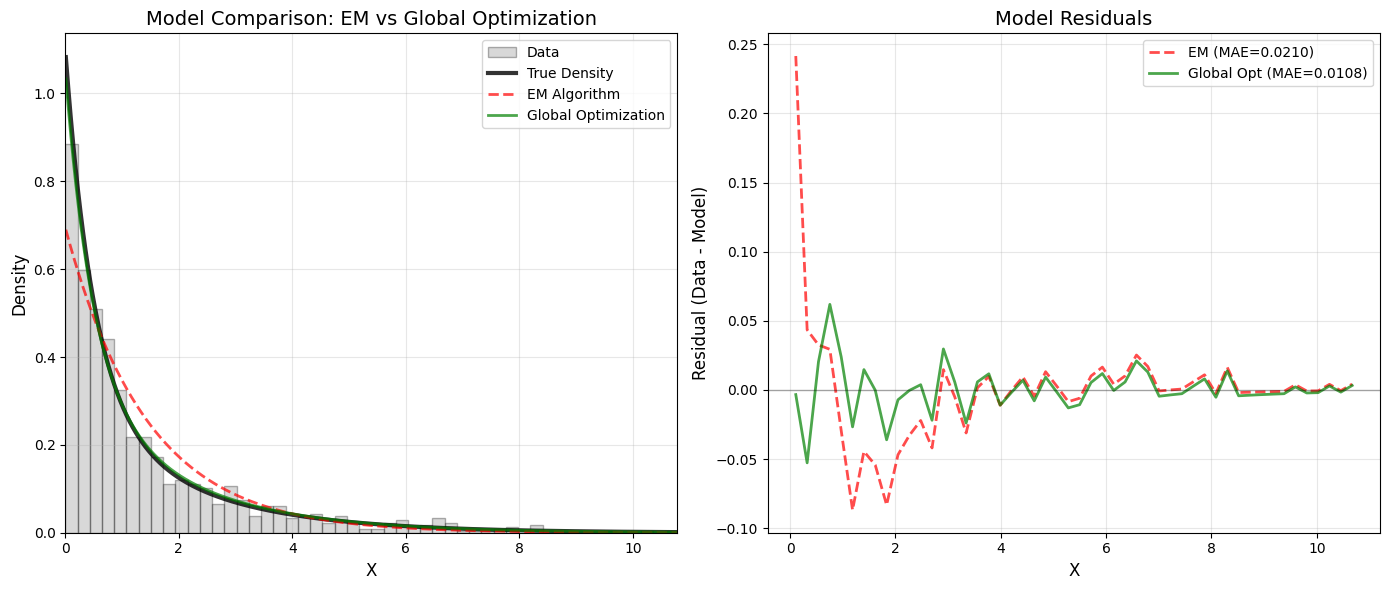


Mean Absolute Error (MAE):
  EM Algorithm:        0.020957
  Global Optimization: 0.010826


In [28]:
# Plot comparison of all methods
x_range = np.linspace(0.01, X.max(), 1000)

# True density
true_density = (true_pi * true_lambda1 * np.exp(-true_lambda1 * x_range) + 
                (1 - true_pi) * true_lambda2 * np.exp(-true_lambda2 * x_range))

# EM density
em_density = (result['pi'] * result['lambda1'] * np.exp(-result['lambda1'] * x_range) + 
              (1 - result['pi']) * result['lambda2'] * np.exp(-result['lambda2'] * x_range))

# Global optimization density
global_density = (pi_global * lambda1_global * np.exp(-lambda1_global * x_range) + 
                  (1 - pi_global) * lambda2_global * np.exp(-lambda2_global * x_range))

plt.figure(figsize=(14, 6))

# Left plot: Data and fits
plt.subplot(1, 2, 1)
plt.hist(X, bins=50, density=True, alpha=0.3, edgecolor='black', label='Data', color='gray')
plt.plot(x_range, true_density, 'k-', linewidth=3, label='True Density', alpha=0.8)
plt.plot(x_range, em_density, 'r--', linewidth=2, label='EM Algorithm', alpha=0.7)
plt.plot(x_range, global_density, 'g-', linewidth=2, label='Global Optimization', alpha=0.7)
plt.xlabel('X', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Model Comparison: EM vs Global Optimization', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(0, x_range.max())

# Right plot: Residuals
plt.subplot(1, 2, 2)
hist_vals, bin_edges = np.histogram(X, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate densities at bin centers
true_dens_bins = (true_pi * true_lambda1 * np.exp(-true_lambda1 * bin_centers) + 
                  (1 - true_pi) * true_lambda2 * np.exp(-true_lambda2 * bin_centers))
em_dens_bins = (result['pi'] * result['lambda1'] * np.exp(-result['lambda1'] * bin_centers) + 
                (1 - result['pi']) * result['lambda2'] * np.exp(-result['lambda2'] * bin_centers))
global_dens_bins = (pi_global * lambda1_global * np.exp(-lambda1_global * bin_centers) + 
                    (1 - pi_global) * lambda2_global * np.exp(-lambda2_global * bin_centers))

plt.plot(bin_centers, hist_vals - em_dens_bins, 'r--', linewidth=2, 
         label=f'EM (MAE={np.mean(np.abs(hist_vals - em_dens_bins)):.4f})', alpha=0.7)
plt.plot(bin_centers, hist_vals - global_dens_bins, 'g-', linewidth=2, 
         label=f'Global Opt (MAE={np.mean(np.abs(hist_vals - global_dens_bins)):.4f})', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
plt.xlabel('X', fontsize=12)
plt.ylabel('Residual (Data - Model)', fontsize=12)
plt.title('Model Residuals', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMean Absolute Error (MAE):")
print(f"  EM Algorithm:        {np.mean(np.abs(hist_vals - em_dens_bins)):.6f}")
print(f"  Global Optimization: {np.mean(np.abs(hist_vals - global_dens_bins)):.6f}")